On final dataset, using only labeled images ; Resnet18 -> Linear

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image # pip3 install pillow
import random
import cv2
import time
import os

In [39]:
df = pd.read_pickle("data/dataset.pkl")
df.head()

,image,points,labeled
0,data/dactar/1300_img.png,"[177.16228095049055, 184.83182101741053, 244.7...",1
1,data/dactar/1766_img.png,"[409.7109787838158, 362.74050003943523, 536.55...",1
2,data/dactar/130_img.png,"[386.66894459252546, 342.1963080587535, 503.59...",1
3,data/dactar/1785_img.png,"[197.75577726950075, 171.98786970581278, 250.1...",1
4,data/dactar/617_img.png,"[180.14505945291972, 298.14972872833135, 288.5...",1


In [42]:
img_folder = "test/"
imlist = []
for (dirpath, dirnames, filenames) in os.walk(img_folder):
#     imlist.extend(filenames)
    imlist.extend([os.path.join(dirpath, filename) for filename in filenames])

# imlist =[f for f in os.listdir(img_folder) 
#          if os.path.isfile(os.path.join(img_folder, f))]
len(imlist), imlist[0]

(80, 'test/dactar/302_img.png')

In [50]:
data_list = []
all_imgs = [imgname.replace("data","test") for imgname in df.image.tolist()]
for img in imlist:
    try:
        indx = all_imgs.index(img)
        tokeep.append(indx)
#         data_list.append([df.iloc[indx].image, df.iloc[indx].points])
#         data_list.append([os.path.join(img_folder, df.iloc[indx].image.split('/')[-1]), df.iloc[indx].points])
        data_list.append([all_imgs[indx], df.iloc[indx].points])

    except ValueError as e:
        continue
df_test = pd.DataFrame(data=data_list, columns=["image", "points"])
print(len(imlist), len(df_test))
df_test.head()

80 80


,image,points
0,test/dactar/302_img.png,"[311.5482687909141, 263.43743197413045, 412.96..."
1,test/dactar/643_img.png,"[200.52462157335316, 178.39022592894423, 270.9..."
2,test/dactar/4_img.png,"[731.6394153243285, 558.4904461359735, 881.935..."
3,test/dactar/833_img.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,test/dactar/246_img.png,"[159.01733886166608, 167.15541582428125, 239.7..."


In [51]:
# df_test1 = df.iloc[tokeep].reset_index()
# df_test = df_test1.copy()
# df_test

In [52]:
# all_imgs = [os.path.join(img_folder, imgname.split('/')[-1]) for imgname in df_test.image.tolist()]
# df_test1 = df_test.drop(columns=['image'])
# df_test1['image'] = all_imgs
# df_test1 = df_test1[["image", "points"]]
# df_test1

test/jeevan/571_img.png [136.06358885 219.09233449 220.85452962 214.23170732 220.85452962
 235.29442509 136.06358885 240.15505226]


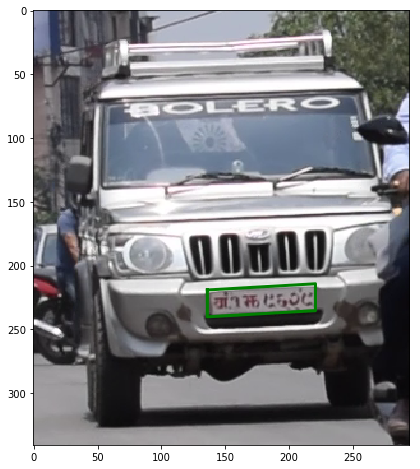

In [89]:
# i=-1
i+=1
path, targ = df_test.iloc[i].image, df_test.iloc[i].points
print(path, targ)
img = Image.open(path).convert('RGB')

targ = np.append(targ, targ[:2]).reshape(-1,2)
# targ = targ.reshape(-1,2)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.plot(targ[:,0], targ[:,1], lw=3, c='g')

### Image Transform

In [90]:
class ResizeAspect(object):
    def __init__(self, h, w):
        self.hw = (h, w)
        self.rescale_factor=None
        self.shift_h=None
        self.shift_w=None
        
    def do_image(self, img):
        h, w = self.hw
        img_h, img_w = img.shape[0], img.shape[1]
        rescale_factor = min(w/img_w, h/img_h)
        new_w = int(img_w * rescale_factor)
        new_h = int(img_h * rescale_factor)
        resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)

        canvas = np.full((h, w, 3), 128, dtype=np.uint8)
        shift_h = (h-new_h)//2
        shift_w = (w-new_w)//2
        canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
        img = canvas.copy()
        self.rescale_factor=rescale_factor
        self.shift_h = shift_h
        self.shift_w = shift_w
        return img
    
    def do_box(self, box):
        box = box.reshape(-1,2)
        box *=self.rescale_factor
        box[: ,0] += self.shift_w
        box[: ,1] += self.shift_h
        box = box.reshape(-1)
        return box
    
    def undo_box(self, box):
        box = box.reshape(-1,2)
        box[: ,0] -= self.shift_w
        box[: ,1] -= self.shift_h
        box /=self.rescale_factor
        box = box.reshape(-1)
        return box

In [91]:
class FinalTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    
    def transform_inv(self,img):
        inp = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp

### Dataset Loader

In [92]:
class LicenseDataset(Dataset):
    def __init__(self, df):
        
        self.imgs = list(df.image)
        self.boxes = df.points.tolist()
        self.final_transform = FinalTransform()
        self.transform = self.final_transform.transform
        self.transform_inv = self.final_transform.transform_inv
        self.resizer = ResizeAspect(h=224, w=224)
            
    def __getitem__(self, index):
        path= self.imgs[index]
        box = self.boxes[index]
        
        
        img = Image.open(path).convert('RGB')
        img = self.resizer.do_image(np.array(img))
        img = self.final_transform.transform(img)
        box = self.resizer.do_box(box)
        box = np.array(box, dtype=np.float32)

        factor = np.array(
            [self.resizer.rescale_factor, self.resizer.shift_h, self.resizer.shift_w],
            dtype=np.float32
        )
        return img, box, factor, index
      
    
    def __len__(self):
        return len(self.imgs)

In [93]:
test = LicenseDataset(df_test)

In [94]:
test_loader = torch.utils.data.DataLoader(
                test, batch_size=32,shuffle=False,
                num_workers=4, pin_memory=True)

### Defining Model

In [95]:
model = models.resnet18(pretrained=True)
'''
output of our model is :
x1, y1,
x2, y2,
x3, y3,
x4, y4,
conf -> only when no bounding box images are taken
'''
num_feature = model.fc.in_features
num_output = 8#9
model.fc = nn.Linear(num_feature, num_output)
model = model.cpu()

In [96]:
model.load_state_dict(torch.load('saved_states/model_state_v0.pth', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [97]:
test_batch = 0
indx = -1
model.eval()
print('Working in test mode')

Working in test mode


In [98]:
# if indx < 0:
#     for j,(ims, boxes, factors, index) in enumerate(test_loader):
#         if j<test_batch:
#             continue
#         index = index.cpu().numpy()
#         inputs = ims.cpu()
#         targets = boxes.cpu().numpy()
#         factors = factors.cpu().numpy()
#         outputs = model(inputs)
#         outputs = outputs.data.cpu().numpy()
#         test_batch +=1
#         break
    
# indx +=1
# loader_indx = index[indx]
# factor = factors[indx]
# resizer = test.resizer


# path= test.imgs[loader_indx]
# img = Image.open(path).convert('RGB')
# resizer.rescale_factor=factor[0]
# resizer.shift_h=factor[1]
# resizer.shift_w=factor[2]


# targ = test.boxes[loader_indx]
# targ = np.append(targ, targ[:2]).reshape(-1,2)

# out = outputs[indx]
# # print(out)
# # print(resizer, resizer.rescale_factor, resizer.shift_h, resizer.shift_w)
# out = resizer.undo_box(out)
# out = np.append(out, out[:2]).reshape(-1,2)

# plt.figure(figsize=(8, 8))
# plt.imshow(img)
# plt.plot(targ[:,0], targ[:,1], lw=3, c='g')
# plt.plot(out[:,0], out[:,1], lw=3, c='r')
# print(indx)
# if indx == 31:
#     indx = -1

In [101]:
resizer = test.resizer
for j,(ims, boxes, factors, index) in enumerate(test_loader):

    index = index.cpu().numpy()
    inputs = ims.cpu()
    targets = boxes.cpu().numpy()
    factors = factors.cpu().numpy()
    outputs = model(inputs)
    outputs = outputs.data.cpu().numpy()

    for indx in range(len(outputs)):
        loader_indx = index[indx]
        factor = factors[indx]

        path= test.imgs[loader_indx]
        img = Image.open(path).convert('RGB')
        resizer.rescale_factor=factor[0]
        resizer.shift_h=factor[1]
        resizer.shift_w=factor[2]

        targ = test.boxes[loader_indx]
        targ = np.append(targ, targ[:2]).reshape(-1,2)

        out = outputs[indx]
        out = resizer.undo_box(out)
        out = np.append(out, out[:2]).reshape(-1,2)

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.plot(targ[:,0], targ[:,1], lw=3, c='g')
        plt.plot(out[:,0], out[:,1], lw=3, c='r')
        plt.savefig("pred_"+path)
        plt.clf()

/home/tsuman/Program_Files/miniconda3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>